# Factor Analysis of Mixed Data with &nbsp;<a href="https://www.python.org/"><img src="https://s3.dualstack.us-east-2.amazonaws.com/pythondotorg-assets/media/community/logos/python-logo-only.png" style="max-width: 35px; display: inline" alt="R"/></a>

## _Titanic Survival Prediction_

---

In this tutorial, we will use the [titanic dataset](https://www.kaggle.com/competitions/titanic/data), from Kaggle competition "_Titanic - Machine Learning from Disaster_".

Our aim here is to mobilise several dimension reduction algorithms covered in the lesson (PCA, MCA) and attempt to predict passengers' chances of survival.
As prediction algorithms are not at the heart of this course (unlike Machine Learning!), we will not optimise this part: we could implement much more efficient algorithms than the naive ones proposed here.

For this tutorial, we will be using the [`prince`](https://maxhalford.github.io/prince/) package, based on the same syntax as scikit-learn.

---

In [1]:
pip install prince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 2.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import prince

import matplotlib.pyplot as plt
import seaborn as sns

---
## Data Loading

First of all, we need to load the data and clean it up to make it easier to use. The Titanic dataset is available in `Seaborn` as the `titanic` datase. It consists of the following columns:

- survived: Survival status (0 = No, 1 = Yes)
- pclass: Passenger class (1 = 1st class, 2 = 2nd class, 3 = 3rd class)
- sex: Passenger’s gender
- age: Passenger’s age
- sibsp: Number of siblings/spouses aboard
- parch: Number of parents/children aboard
- fare: Fare paid for the ticket
- embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
- class: Equivalent to pclass (1 = 1st class, 2 = 2nd class, 3 = 3rd class)
- who: Passenger’s category (man, woman, child)
- adult_male: Whether the passenger is an adult male or not (True or False)
- deck: Cabin deck
- embark_town: Port of embarkation (Cherbourg, Queenstown, Southampton)
- alive: Survival status (yes or no)
- alone: Whether the passenger is alone or not (True or False)

In [3]:
# Load Data

titanic = sns.load_dataset("titanic")
titanic.head()
print(titanic)

     survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0           0       3    male  22.0      1      0   7.2500        S   Third   
1           1       1  female  38.0      1      0  71.2833        C   First   
2           1       3  female  26.0      0      0   7.9250        S   Third   
3           1       1  female  35.0      1      0  53.1000        S   First   
4           0       3    male  35.0      0      0   8.0500        S   Third   
..        ...     ...     ...   ...    ...    ...      ...      ...     ...   
886         0       2    male  27.0      0      0  13.0000        S  Second   
887         1       1  female  19.0      0      0  30.0000        S   First   
888         0       3  female   NaN      1      2  23.4500        S   Third   
889         1       1    male  26.0      0      0  30.0000        C   First   
890         0       3    male  32.0      0      0   7.7500        Q   Third   

       who  adult_male deck  embark_town alive  alo

##### <span style="color:purple">**Todo:** Clean the data.</span>

1. Remove any redundant variables

2. Manage missing values.
    - Check whether or not the data contain missing values,
    - Where this seems reasonable (not too many missing values, not too many modalities in the case of a categorical variable, etc.):
        - Imput to the median for missing quantitative values,
        - Imput to the most frequent modality for missing qualitative values.    <br><br>
        
3. Create a new 'family_size' variable that counts the number of siblings/spouses and parents/children aboard.
    
---

The command `print(titanic.isnull().sum())` should produce the following output:
```
survived       0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
alone          0
family_size    0
```

=== Non-meaningful columns ===
Remove the columns: ['alive', 'embark_town', 'pclass']

=== Missing values ===
Columns containing missing values are: ['age', 'embarked', 'deck']

Embarked - Rate of missing values: 0.22446689113355783
Port with more frequent boarding: Southampton
--> We fill _embarked_ with Southampton

Age - Rate of missing values: 19.87%
Age is a quantitative variable
--> We fill _age_ with the median of titanic[age]

Deck - Rate of missing values: 77.22%
The deck variable has too many missing values + It makes no sense to use the most common category here.
--> We remove it from the dataset

=== Checking ===
survived       0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
alone          0
family_size    0
dtype: int64


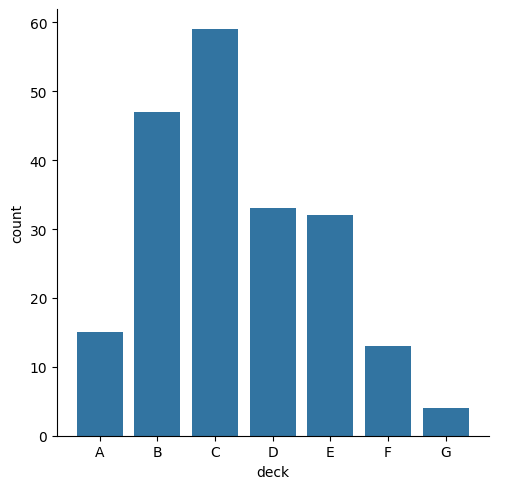

In [4]:
# %load solutions/data/clean_data.py
# seq = list(titanic.columns[ titanic.nunique() > .5*titanic.shape[0] ])

print('=== Non-meaningful columns ===')
print('Remove the columns:', ['alive', 'embark_town', 'pclass'])

# --- #
# Alive vs. Survived

titanic.drop('alive', axis=1, inplace=True)
titanic['survived'] = titanic['survived'].astype('category')
titanic['survived'] = titanic['survived'].cat.rename_categories({0: 'No', 1:'Yes'})

# --- #
# Embark_town vs Embarked

titanic.drop('embark_town', axis=1, inplace=True)
titanic['embarked'] = titanic['embarked'].astype('category')
titanic['embarked'] = titanic['embarked'].cat.rename_categories({'S': 'Southampton', 'C':'Cherbourg', 'Q':'Queenstown'})

# --- #
# Pclass

titanic.drop('pclass', axis=1, inplace=True)


# --- # --- #

print('')
print('=== Missing values ===')
print('Columns containing missing values are:', list(titanic.columns[titanic.isnull().sum()!=0]))

# --- #
# Embarked

print('')
print('Embarked - Rate of missing values:', titanic['embarked'].isnull().sum()/titanic.shape[0]*100)

E = titanic['embarked'].mode()[0]
titanic['embarked'].fillna(E, inplace=True)


print('Port with more frequent boarding:', E)
print('--> We fill _embarked_ with', E)

# --- #
# Age

print('')
print('Age - Rate of missing values: {:.2f}%'.format(titanic['age'].isnull().sum()/titanic.shape[0]*100))
print('Age is a quantitative variable')
print('--> We fill _age_ with the median of titanic[age]')

titanic.fillna({'age': titanic['age'].median()}, inplace=True)

# --- #
# Deck

print('')
print('Deck - Rate of missing values: {:.2f}%'.format(titanic['deck'].isnull().sum()/titanic.shape[0]*100))

sns.catplot(data=titanic, x="deck", kind="count")
plt.plot()

print('The deck variable has too many missing values + It makes no sense to use the most common category here.')
print('--> We remove it from the dataset')

titanic.drop('deck', axis=1, inplace=True)

# --- #
# family_size
titanic['family_size'] = titanic['sibsp'] + titanic['parch']

# --- #

print('')
print('=== Checking ===')
print(titanic.isnull().sum())

##### <span style="color:purple">**Todo:** Outliers detection.</span>

Based on the two figures below, would you say that the data shows outliers? If so, remove them.

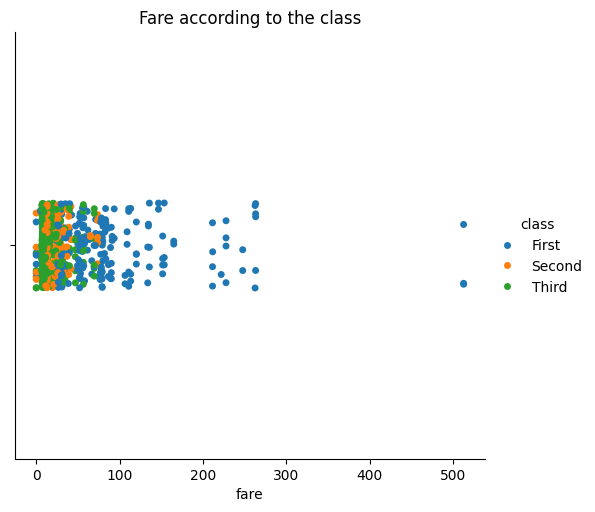

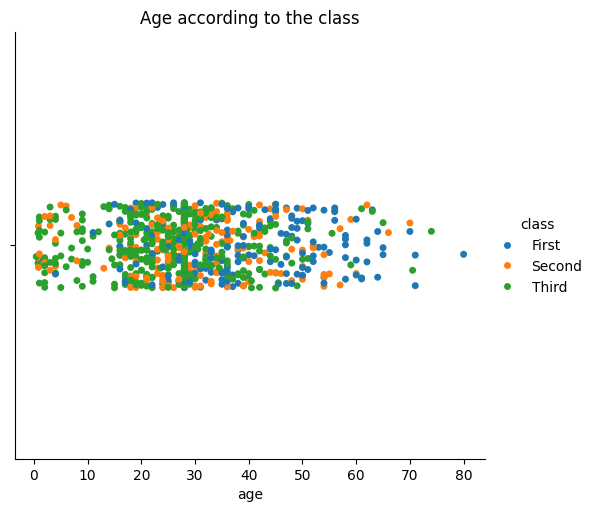

In [5]:
# Fare
sns.catplot(data=titanic, x='fare', hue='class')
plt.title('Fare according to the class')
plt.show()

# Age
sns.catplot(data=titanic, x='age', hue='class')
plt.title('Age according to the class')
plt.show()

In [ ]:
### TO BE COMPLETED ###

#removed_outliers = titanic[titanic['fare'] <= threshold]


In [6]:
# %load solutions/data/outliers.py
# Outliers detection

#On enlève ceux qui payent 0 car ils ne peuvent pas être sur le bateau
print('=== Outliers detection ===')
cpt = np.sum(titanic['fare']==0)
print('We will remove {:} lines'.format(cpt))

titanic = titanic[titanic['fare'] != 0]
print('"New" titanic dataset shape:', titanic.shape)

display(titanic)

=== Outliers detection ===
We will remove 15 lines
"New" titanic dataset shape: (876, 12)


,survived,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,alone,family_size
0,No,male,22.0,1,0,7.2500,Southampton,Third,man,True,False,1
1,Yes,female,38.0,1,0,71.2833,Cherbourg,First,woman,False,False,1
2,Yes,female,26.0,0,0,7.9250,Southampton,Third,woman,False,True,0
3,Yes,female,35.0,1,0,53.1000,Southampton,First,woman,False,False,1
4,No,male,35.0,0,0,8.0500,Southampton,Third,man,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,No,male,27.0,0,0,13.0000,Southampton,Second,man,True,True,0
887,Yes,female,19.0,0,0,30.0000,Southampton,First,woman,False,True,0
888,No,female,28.0,1,2,23.4500,Southampton,Third,woman,False,False,3
889,Yes,male,26.0,0,0,30.0000,Cherbourg,First,man,True,True,0


##### <span style="color:purple">**Todo:** Explore the profile of the passengers on the titanic.</span>

1. View the distribution of the passenger according to their status (man, woman, child), according to their class, _etc._
2. View the breakdown of passengers who survived the shipwreck
3. How does the survival rate change depending on the class and type of passenger (male, female, child)?
4. What is the age profile of passengers according to the class of their ticket?
5. Same question with ticket prices
6. Do ticket prices seem to depend on the age of passengers?

In [ ]:
# Passenger distribution

### TO BE COMPLETED ###

[...]

[Ellipsis]

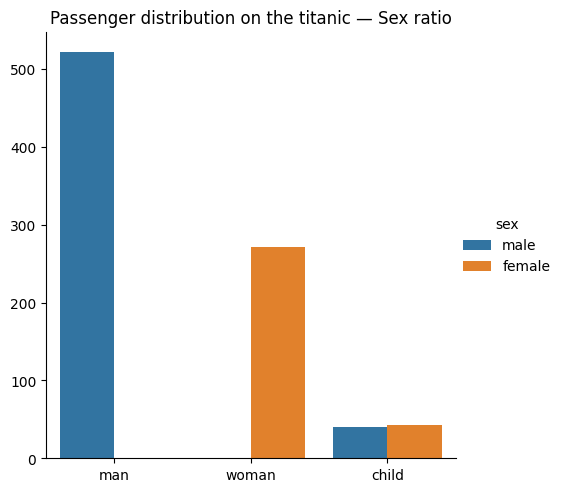

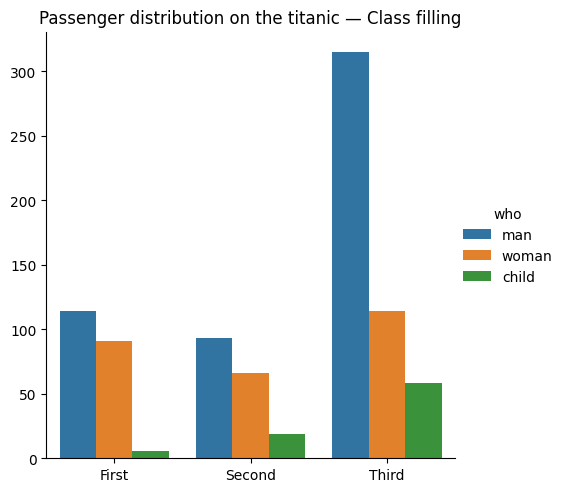

In [7]:
# %load solutions/data/passengers.py
# Passengers distribution

fig = sns.catplot(data=titanic, x='who', kind='count', hue='sex')


plt.xlabel('')
plt.ylabel('')
plt.title('Passenger distribution on the titanic — Sex ratio')
plt.show()

# --- #
print('')

fig = sns.catplot(data=titanic, x='class', kind='count', hue='who')

plt.xlabel('')
plt.ylabel('')
plt.title('Passenger distribution on the titanic — Class filling')
plt.show()

In [ ]:
# Survival Count

titanic.survived.replace(('Yes', 'No'), (1, 0), inplace=True)
titanic.who.replace(('man', 'woman', 'child'), (0, 1, 2), inplace=True)
print(titanic)

    survived     sex   age  sibsp  parch     fare     embarked   class  who  \
0          0    male  22.0      1      0   7.2500  Southampton   Third    0   
1          1  female  38.0      1      0  71.2833    Cherbourg   First    1   
2          1  female  26.0      0      0   7.9250  Southampton   Third    1   
3          1  female  35.0      1      0  53.1000  Southampton   First    1   
4          0    male  35.0      0      0   8.0500  Southampton   Third    0   
..       ...     ...   ...    ...    ...      ...          ...     ...  ...   
886        0    male  27.0      0      0  13.0000  Southampton  Second    0   
887        1  female  19.0      0      0  30.0000  Southampton   First    1   
888        0  female  28.0      1      2  23.4500  Southampton   Third    1   
889        1    male  26.0      0      0  30.0000    Cherbourg   First    0   
890        0    male  32.0      0      0   7.7500   Queenstown   Third    0   

     adult_male  alone  family_size  
0          Tr

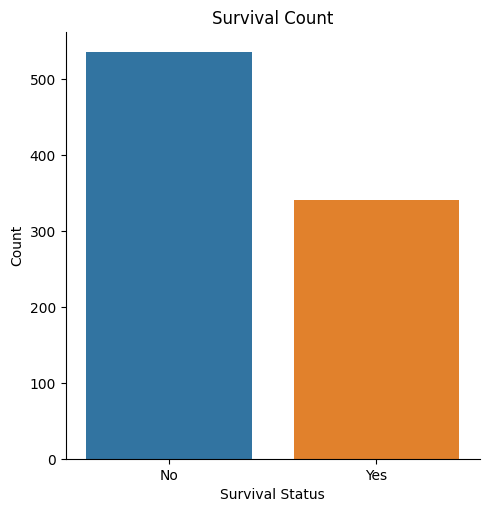

In [8]:
# %load solutions/data/survival.py
# Survival Count

sns.catplot(data=titanic, x='survived', kind='count', hue='survived')

plt.xlabel('Survival Status')
plt.ylabel('Count')
plt.title('Survival Count')
plt.show()

In [9]:
# Survival depending on sex and class

### TO BE COMPLETED ###



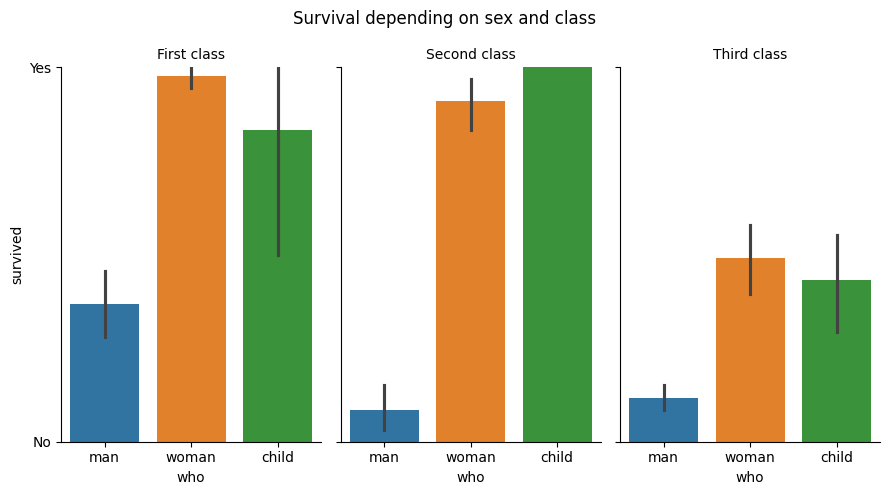

In [10]:
# %load solutions/data/survival_sex_class.py
# Survival depending on sex and class


fig = sns.catplot(
    data=titanic,
    x='who', y='survived', col='class',
    hue='who', kind='bar',
    aspect=.6
)

plt.suptitle('Survival depending on sex and class')
fig.set_titles("{col_name} {col_var}")
fig.set(ylim=(0, 1))

plt.tight_layout()
plt.show()

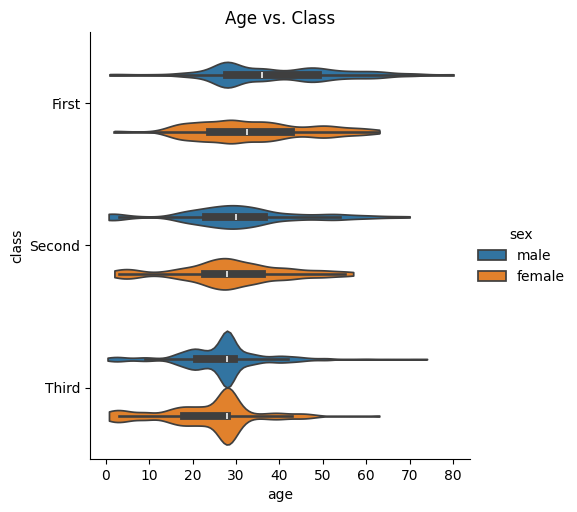

In [12]:
# %load solutions/data/aga_class.py
# Age vs. Class

sns.catplot(
    data=titanic, x='age', y='class', hue='sex',
    kind="violin", bw_adjust=.5, cut=0, #split=True
)
plt.title('Age vs. Class')
plt.show()

In [ ]:
# Class vs. Fare

### TO BE COMPLETED ###

[...]

[Ellipsis]

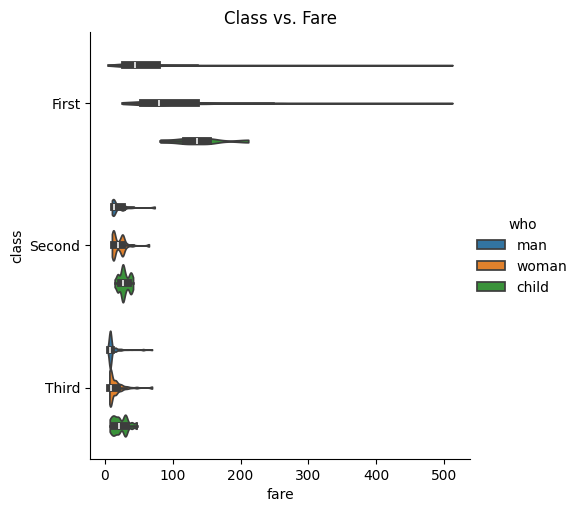

In [13]:
# %load solutions/data/class_fare.py
# Class vs. Fare

sns.catplot(
    data=titanic, x='fare', y='class', hue='who',
    kind='violin', bw_adjust=.5, cut=0,
)
plt.title('Class vs. Fare')
plt.show()

In [ ]:
# Age vs. Fare

### TO BE COMPLETED ###

[...]

[Ellipsis]

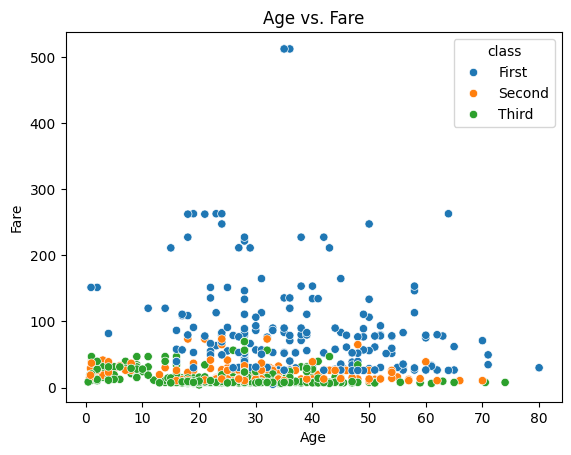

In [14]:
# %load solutions/data/age_fare.py
# Age vs. Fare
sns.scatterplot(data=titanic, x="age", y="fare", hue="class")

plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Age vs. Fare')
plt.show()

##### <span style="color:purple">**Question:** Under what age are passengers considered to be children?</span>

In [16]:
# %load solutions/data/children.py
m = max(titanic['age'][titanic['who'] == 'child'])
print('To be considered as children, passengers must be under', int(m))

To be considered as children, passengers must be under 15


##### <span style="color:purple">**Todo:** Visualize correlations between features.</span>

- What do you think?

In [ ]:
### TO BE COMPLETED ###

[...]

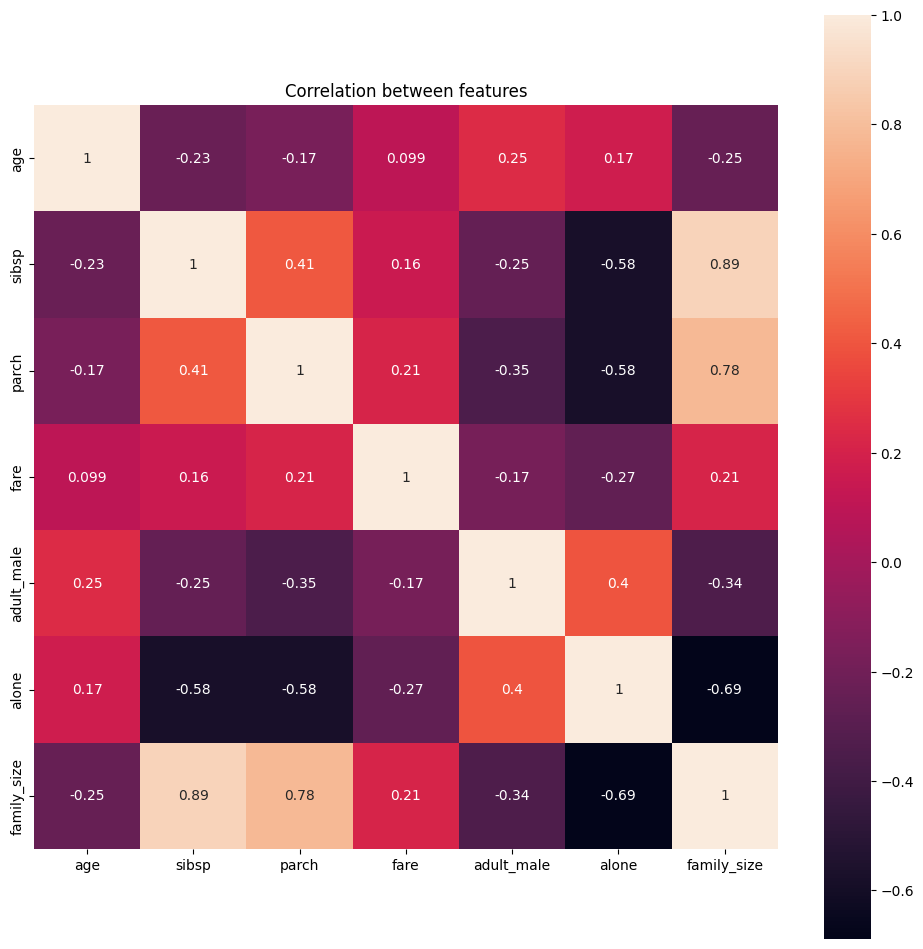

In [17]:
# %load solutions/data/correlation.py
corr = titanic.corr(numeric_only=True)

plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, square=True, cmap='rocket')
plt.title('Correlation between features')
plt.show()

## Principal Component Analysis

PCA is the usual dimension reduction technique when working with quantitative variables.

##### <span style="color:purple">**Todo:** Using the `prince` package, perform a [PCA](https://maxhalford.github.io/prince/pca/).</span>

- Restrict to quantitative variables: survived, age, fare and family_size.
- Fit the model.

In [ ]:
### TO BE COMPLETED ###

titanic_quanti = ...
titanic_quanti = titanic_quanti.set_index('survived')

[...]

In [18]:
# %load solutions/pmca/titanic_quanti.py
titanic_quanti = titanic[['survived','age','fare','family_size']]
titanic_quanti = titanic_quanti.set_index('survived')

pca = prince.PCA(
    n_components=5,
    n_iter=10,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
pca = pca.fit(titanic_quanti)

##### <span style="color:purple">**Question:** What do you think of the inertia carried by each axis?</span>

- Consider the `eigenvalues_summary` function
- and/or view the `scree_plot`

In [ ]:
### TO BE COMPLETED ###

In [35]:
# %load solutions/pmca/pca_eigenvalues.py
display(pca.eigenvalues_summary)

pca.scree_plot()

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,1.280,42.66%,42.66%
1,1.098,36.59%,79.25%
2,0.623,20.75%,100.00%


alt.Chart(...)

##### <span style="color:purple">**Question:** Do you think we could easily predict the survival rate in PCA space?</span>

- Show the projections of the points in the principal maps, colored according to their survival rate.
- Refer to Prince's help for figures.

In [ ]:
### TO BE COMPLETED ###

[...]

In [20]:
# %load solutions/pmca/plot_pca_prince.py
pca.plot(titanic_quanti,
         x_component=0,
         y_component=1
         #color_rows_by='survived',
         #show_row_markers=True,
         #show_column_markers=True
)





alt.LayerChart(...)

In [21]:

pca.plot(titanic_quanti,
         x_component=0,
         y_component=2,
         color_rows_by='survived',
         show_row_markers=True,
         show_column_markers=True
)


alt.LayerChart(...)

In [22]:
pca.plot(titanic_quanti,
         x_component=1,
         y_component=2,
         color_rows_by='survived',
         show_row_markers=True,
         show_column_markers=True
)

alt.LayerChart(...)

> *Disclaimer:* If you get an error message when calling the Prince `plot` function on your machine (as is the case on mine), you can use the function below.

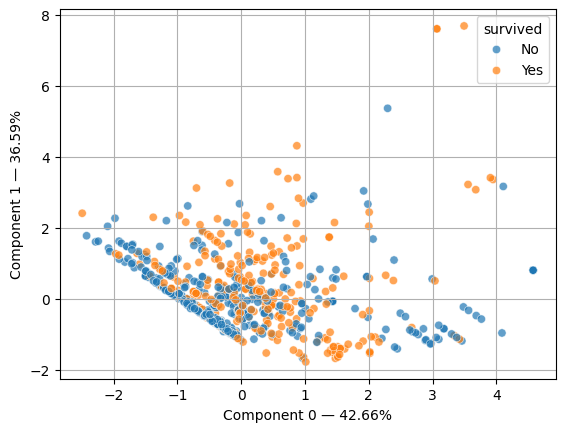

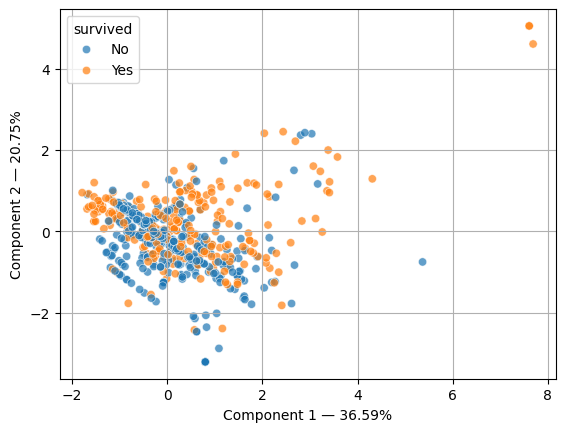

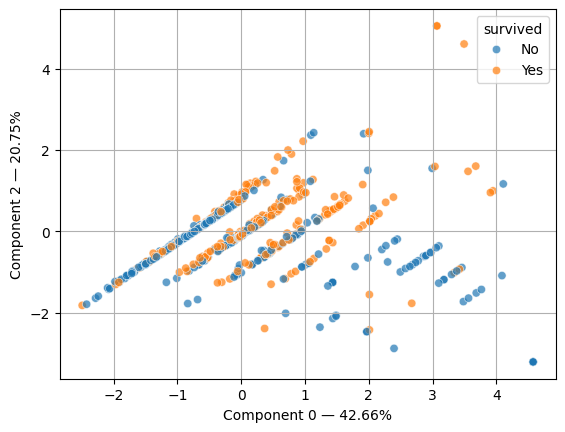

In [23]:
# %load solutions/pmca/plot_pca.py
def plot_pca(ax1=0, ax2=1, pca=pca, data=titanic_quanti):
  dataset = pca.transform(data)
  dataset.reset_index(inplace=True)
  sns.scatterplot(data = dataset,
                  x = ax1, y = ax2,
                  hue = 'survived', alpha=.7)

  plt.xlabel('Component {} — {:.2f}%'.format(ax1, pca.percentage_of_variance_[ax1]))
  plt.ylabel('Component {} — {:.2f}%'.format(ax2, pca.percentage_of_variance_[ax2]))
  plt.grid(True)
  plt.show()

plot_pca(0,1)
plot_pca(1,2)
plot_pca(0,2)

## Multiple Correspondence Analysis

MCA is the usual dimension reduction technique when working with qualitative variables.

##### <span style="color:purple">**Question:** Does it seem reasonable to assume family size as a qualitative variable?</span>

In [24]:
### TO BE COMPLETED ###

[...]

[Ellipsis]

[]

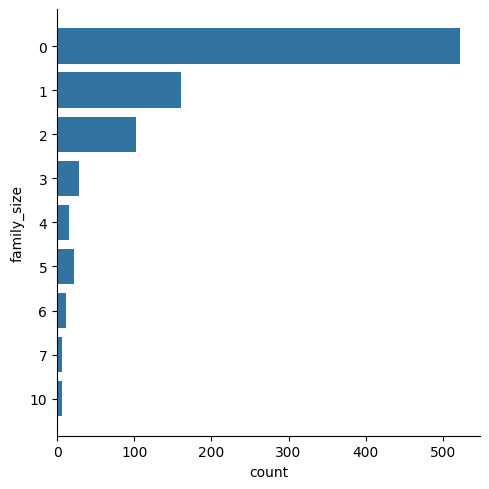

In [25]:
# %load solutions/pmca/family_size.py
sns.catplot(titanic['family_size'].astype('category'), kind='count')
plt.plot()

##### <span style="color:purple">**Question:** How many modalities does the dataset contain, taking `family_size` as a qualitative variable? And without?</span>

In [ ]:
### TO BE COMPLETED ###

[...]

In [30]:
# %load solutions/pmca/titanic_quali.py

titanic_quali = titanic[['survived','embarked','class','who','alone']] #,'family_size'
titanic_quali = titanic_quali.astype('category')
titanic_quali = titanic_quali.set_index('survived')

pd.get_dummies(titanic_quali)
#11 modalités sans family_size

titanic_quali2 = titanic[['survived','embarked','class','who','alone','family_size']]
titanic_quali2= titanic_quali2.astype('category')
titanic_quali2= titanic_quali2.set_index('survived')

pd.get_dummies(titanic_quali2)
#20 modalités sans family_size



,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton,class_First,class_Second,class_Third,who_child,who_man,who_woman,alone_False,alone_True,family_size_0,family_size_1,family_size_2,family_size_3,family_size_4,family_size_5,family_size_6,family_size_7,family_size_10
survived,,,,,,,,,,,,,,,,,,,,
No,False,False,True,False,False,True,False,True,False,True,False,False,True,False,False,False,False,False,False,False
Yes,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False
Yes,False,False,True,False,False,True,False,False,True,False,True,True,False,False,False,False,False,False,False,False
Yes,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False
No,False,False,True,False,False,True,False,True,False,False,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
No,False,False,True,False,True,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False
Yes,False,False,True,True,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False
No,False,False,True,False,False,True,False,False,True,True,False,False,False,False,True,False,False,False,False,False


##### <span style="color:purple">**Todo:** Using the `prince` package, perform a [MCA](https://maxhalford.github.io/prince/mca/).</span>

- Restrict to qualitative variables: survived, embarked, class, who, alone and possibly family_size
- Fit the model.

In [40]:
### TO BE COMPLETED ###
mca = prince.MCA(
    n_components=14,
    n_iter=10,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(titanic_quali)

In [32]:
%load solutions/pmca/mca.py

ValueError: 'solutions/pmca/mca.py' was not found in history, as a file, url, nor in the user namespace.

##### <span style="color:purple">**Question:** What do you think of the inertia carried by each axis?</span>

- Consider the `eigenvalues_summary` function
- and/or view the `scree_plot`

In [41]:
### TO BE COMPLETED ###

display(mca.eigenvalues_summary)

mca.scree_plot()

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.389,22.22%,22.22%
1,0.326,18.60%,40.82%
2,0.295,16.87%,57.70%
3,0.265,15.14%,72.83%
4,0.193,11.01%,83.84%
5,0.153,8.74%,92.58%
6,0.130,7.42%,100.00%
7,0.000,0.00%,100.00%
8,0.000,0.00%,100.00%


alt.Chart(...)

In [ ]:
# %load solutions/pmca/mca_eigenvalues.py

##### <span style="color:purple">**Todo:** View MCA results.</span>

In [42]:
### TO BE COMPLETED ###

mca.plot(
    titanic_quali,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)

alt.LayerChart(...)

In [ ]:
# %load solutions/pmca/plot_mca_prince.py

##### <span style="color:purple">**Todo:** Write a function `plot_mca`.</span>

- The function `plot_mca(ax1=0, ax2=1, mca=mca, data=titanic_quali)` plots the dataset projections on the MCA plane (ax1, ax2), colored according to the overvis of the passengers.
- Choose colors consistent with the previous PCA graph.
- Label each axis with the percentage of variance it explains (based on the graph above).

In [44]:
### TO BE COMPLETED ###

def plot_mca(ax1=0, ax2=1, mca=mca, data=titanic_quali):
  dataset = mca.transform(data)
  dataset.reset_index(inplace=True)
  sns.scatterplot(data = dataset,
                  x = ax1, y = ax2,
                  hue = 'survived', alpha=.7)

  plt.xlabel('Component {} — {:.2f}%'.format(ax1, mca.percentage_of_variance_[ax1]))
  plt.ylabel('Component {} — {:.2f}%'.format(ax2, mca.percentage_of_variance_[ax2]))
  plt.grid(True)
  plt.show()

In [ ]:
# %load solutions/pmca/plot_mca.py

##### <span style="color:purple">**Question:** What do you conclude from the graphs below?</span>

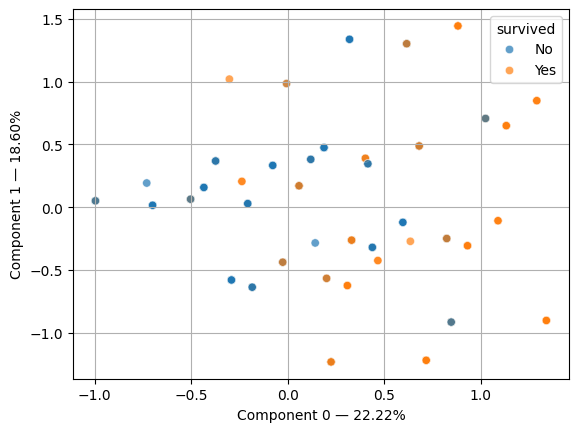

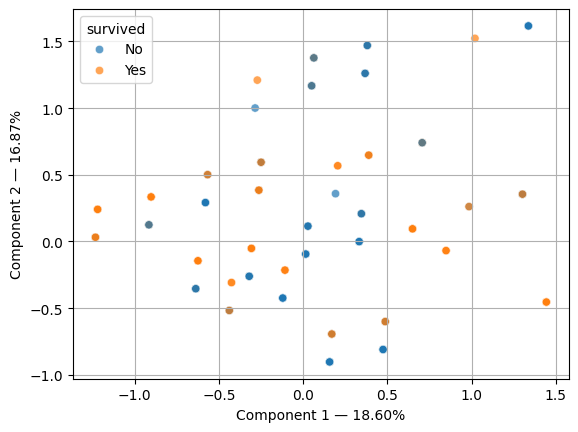

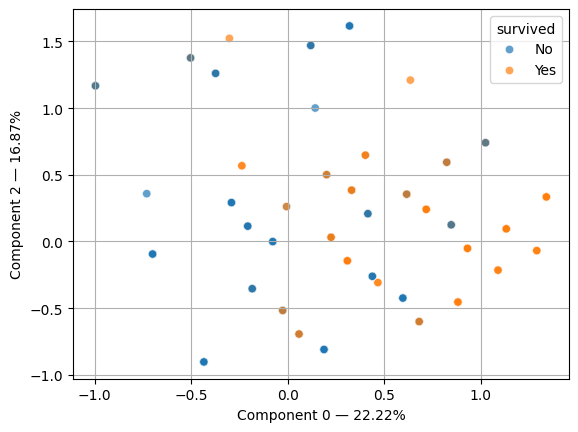

In [45]:
plot_mca(0,1)
plot_mca(1,2)
plot_mca(0,2)

#On voit plein de nuances de couleurs car il y a plusieurs points qui se superposent (plus c'est clair plus il y a d'individus au mm endroit)

##### <span style="color:purple">**Question:** Which variables contribute most strongly to the axes?</span>

In [47]:
### TO BE COMPLETED ###

contrib = mca.column_contributions_.style.format('{:.1%}')
display(contrib.highlight_max(color='orange').highlight_min(color='lightblue'))

,0,1,2,3,4,5,6,7,8,9
embarked_Cherbourg,9.7%,18.0%,3.1%,8.3%,27.6%,13.1%,1.0%,1.3%,14.8%,2.3%
embarked_Queenstown,4.3%,0.8%,40.8%,14.8%,6.9%,23.3%,0.5%,0.6%,6.8%,1.0%
embarked_Southampton,0.8%,3.6%,9.9%,0.0%,13.2%,0.0%,0.6%,5.0%,55.5%,8.6%
class_First,11.0%,26.5%,0.1%,0.6%,6.2%,26.0%,5.5%,8.9%,4.1%,1.1%
class_Second,0.6%,5.9%,27.5%,12.3%,32.2%,0.8%,0.4%,7.5%,3.5%,0.9%
class_Third,7.1%,3.7%,11.5%,2.5%,3.2%,15.1%,1.4%,20.5%,9.6%,2.5%
who_child,8.6%,28.9%,2.5%,17.5%,2.9%,1.8%,28.3%,0.7%,0.5%,7.9%
who_man,11.3%,2.2%,2.3%,7.2%,0.4%,4.5%,12.4%,4.2%,3.2%,49.8%
who_woman,9.3%,0.8%,1.5%,36.6%,3.4%,13.6%,3.8%,2.2%,1.7%,25.9%
alone_False,22.2%,5.8%,0.5%,0.1%,2.4%,1.0%,27.5%,19.9%,0.1%,0.0%


In [ ]:
# %load solutions/pmca/contrib_mca.py

##### <span style="color:purple">**Question:** What do you think of the quality of the representation of individuals? of variables?</span>


In [52]:
### TO BE COMPLETED ###
quality_row = mca.row_cosine_similarities(titanic_quali).head(10).style.format('{:.3}')
display(quality_row)
#Pour le 1er tableau, on voit par exemple que le 1er individu (1ère ligne) est bien représenté par la composante 6

quality_comun = mca.column_cosine_similarities(titanic_quali).style.format('{:.3}')
display(quality_comun.background_gradient())
## on lit sur les colonnes la qualité de la représentation, ici la colonne 2 semble bien représentée

,0,1,2,3,4,5,6,7,8,9
survived,,,,,,,,,,
No,0.00727,0.133,7.78e-07,0.107,0.205,0.00135,0.547,1.01,0.122,0.0316
Yes,2.82,1.28,0.176,0.0182,0.00527,0.0342,0.0191,1.33,0.16,0.0415
Yes,0.0137,0.000258,0.00424,0.0683,0.0551,0.129,0.0565,0.269,0.0325,0.00842
Yes,0.708,0.077,0.00216,0.162,0.467,0.0628,0.00167,0.689,0.0831,0.0215
No,0.161,7.8e-05,0.00289,0.0213,0.0142,0.00906,9.52e-05,0.276,0.0333,0.00863
No,1.56,0.00402,2.14,0.232,0.315,0.638,0.0325,1.33,0.16,0.0415
No,0.0407,0.486,0.15,0.0629,0.141,0.451,0.134,1.01,0.122,0.0316
No,0.133,0.594,0.0441,0.226,0.0113,0.000866,0.0609,0.295,0.0356,0.00924
Yes,0.031,0.0215,0.00783,0.0317,0.0695,0.0455,0.0133,0.152,0.0183,0.00475


,0,1,2,3,4,5,6,7,8,9
embarked_Cherbourg,0.00877,4.89e-05,0.000529,0.000771,8.2e-05,0.00122,2.94e-05,0.0006,0.000644,1.13e-05
embarked_Queenstown,0.00118,0.000171,3.49e-05,0.00157,0.000116,0.00256,0.000909,0.000217,0.000215,3.2e-05
embarked_Southampton,0.00366,0.000207,0.00027,4.23e-07,1.32e-06,1.53e-06,0.000566,0.0418,0.00634,0.000104
class_First,0.00332,0.0018,0.00191,0.00368,0.00409,1.8e-06,7.22e-05,0.0028,0.00584,0.000718
class_Second,0.000165,1.93e-05,0.000998,0.00132,0.000939,8.51e-06,0.0075,0.000786,0.000935,4.73e-07
class_Third,0.0036,0.00161,0.000145,0.00666,0.000914,1.46e-06,0.006,0.0208,4.72e-05,0.00104
who_child,0.00142,2.43e-05,0.000358,5.81e-05,0.00158,0.000855,0.00178,0.00186,0.000314,0.00851
who_man,0.000361,0.000266,0.00196,2.19e-07,0.00033,0.000354,0.00374,0.0276,0.00147,0.00192
who_woman,0.00194,0.000201,0.00122,2.84e-05,3.51e-05,2.1e-06,0.00146,0.000614,0.00145,1.99e-06
alone_False,2.09e-05,0.000488,0.000394,0.00175,0.00119,0.00198,6.65e-05,0.0166,0.00143,0.00302


In [53]:
# %load solutions/pmca/quality_mca.py

## Factor analysis of mixed data

We now consider the following dataset, composed of quantitative _and_ qualitative variables.

**Note**: FAMD is a special case of FMA in which the groups are of mixed type (some quantitative, others qualitative) and of size 1.

In [49]:
titanic_clip = titanic[['survived','age','fare','embarked','class','who','alone']] #,'family_size'
titanic_clip = titanic_clip.set_index('survived')
display(titanic_clip)

,age,fare,embarked,class,who,alone
survived,,,,,,
No,22.0,7.2500,Southampton,Third,man,False
Yes,38.0,71.2833,Cherbourg,First,woman,False
Yes,26.0,7.9250,Southampton,Third,woman,True
Yes,35.0,53.1000,Southampton,First,woman,False
No,35.0,8.0500,Southampton,Third,man,True
...,...,...,...,...,...,...
No,27.0,13.0000,Southampton,Second,man,True
Yes,19.0,30.0000,Southampton,First,woman,True
No,28.0,23.4500,Southampton,Third,woman,False


##### <span style="color:purple">**Todo:** Using the `prince` package, perform a [FAMD](https://maxhalford.github.io/prince/famd/).</span>

- Fit the data
- Vizualise the result of the FAMD (plot)

In [50]:
### TO BE COMPLETED ###

famd = prince.FAMD(
    n_components=9,
    n_iter=10,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)
famd = famd.fit(titanic_clip)

In [ ]:
# %load solutions/pmca/famd.py

##### <span style="color:purple">**Question:** What do you think of the inertia carried by each axis?</span>

- Consider the `eigenvalues_summary` function
- and/or view the `scree_plot`

In [51]:
### TO BE COMPLETED ###

display(famd.eigenvalues_summary)

famd.scree_plot()

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,3.458,21.61%,21.61%
1,3.074,19.22%,40.83%
2,2.390,14.94%,55.77%
3,2.162,13.51%,69.28%
4,1.567,9.79%,79.07%
5,1.296,8.10%,87.18%
6,1.089,6.80%,93.98%
7,0.554,3.46%,97.44%
8,0.409,2.56%,100.00%


alt.Chart(...)

In [ ]:
# %load solutions/pmca/famd_eigenvalues.py

##### <span style="color:purple">**Todo:** Write a function `plot_mca`.</span>

- The function `plot_famd(ax1=0, ax2=1, famd=famd, data=titanic_clip)` plots the dataset projections on the FAMD plane (ax1, ax2), colored according to the overvis of the passengers.
- Choose colors consistent with the previous PCA graph.
- Label each axis with the percentage of variance it explains (based on the graph above).

In [55]:
### TO BE COMPLETED ###

def plot_famd(ax1=0, ax2=1, famd=famd, data=titanic_clip):
  dataset = famd.transform(data)
  dataset.reset_index(inplace=True)
  sns.scatterplot(data = dataset,
                  x = ax1, y = ax2,
                  hue = 'survived', alpha=.7)

  plt.xlabel('Component {} — {:.2f}%'.format(ax1, famd.percentage_of_variance_[ax1]))
  plt.ylabel('Component {} — {:.2f}%'.format(ax2, famd.percentage_of_variance_[ax2]))
  plt.grid(True)
  plt.show()

In [ ]:
# %load solutions/pmca/plot_famd.py

##### <span style="color:purple">**Question:** What do you conclude from the graphs below?</span>


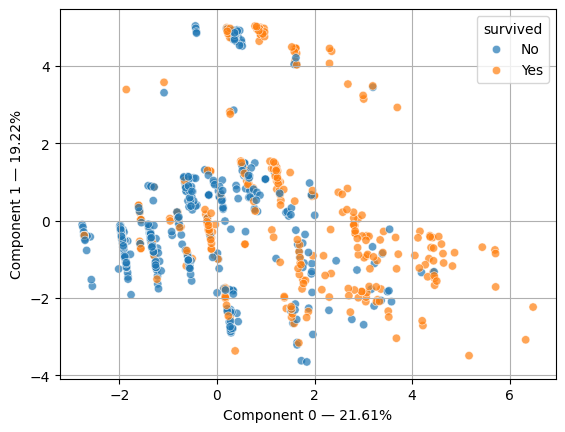

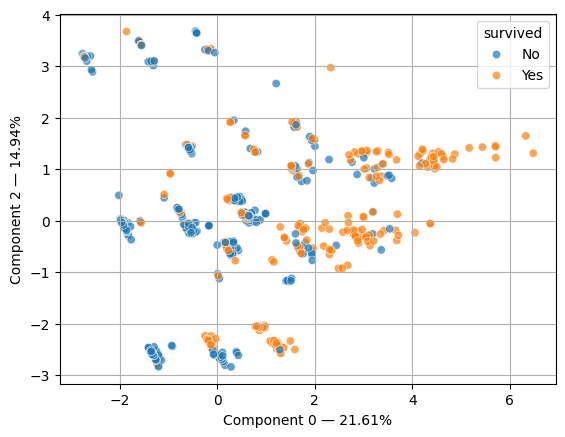

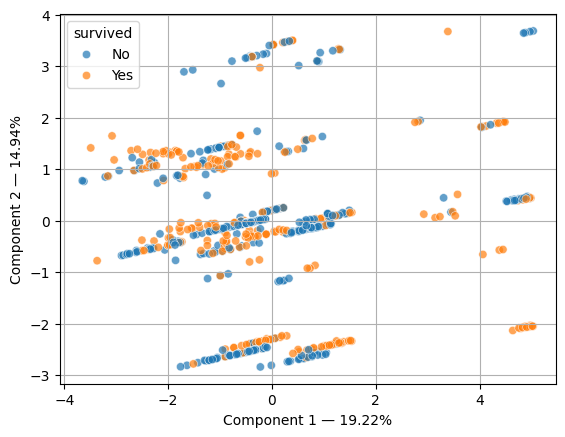

In [56]:
plot_famd(0,1)
plot_famd(0,2)
plot_famd(1,2)

##### <span style="color:purple">**Question:** Which variables contribute most strongly to the axes?</span>

In [57]:
### TO BE COMPLETED ###

contrib = famd.column_contributions_.style.format('{:.2%}')
display(contrib.highlight_max(color='orange').highlight_min(color='lightblue'))

component,0,1,2,3,4,5,6,7,8
variable,,,,,,,,,
age,0.26%,16.29%,0.82%,1.37%,0.47%,0.87%,5.83%,38.34%,35.74%
fare,13.97%,1.05%,0.18%,0.27%,1.40%,4.66%,1.49%,42.17%,34.82%
alone,10.32%,9.97%,0.06%,0.31%,2.56%,0.52%,25.61%,0.02%,0.62%
class,15.88%,6.94%,23.55%,5.30%,18.82%,12.35%,4.62%,2.38%,10.16%
embarked,9.25%,1.14%,25.40%,15.84%,26.79%,19.98%,1.47%,0.07%,0.06%
who,7.43%,23.28%,0.50%,27.73%,0.89%,14.39%,14.64%,7.26%,3.88%


In [ ]:
# %load solutions/pmca/contrib_famd.py

## Survival of the passengers on the titanic

We are now going to take advantage of the dimension reduction techniques we have already seen to make predictions.

First, we perform a classification of the points to assess whether we have correctly understood the distribution of the points. If we do not have access to the labels of the points, we will not be able to take the study any further. However, here we have access to the labels for the points. We therefore decide to apply two common classification algorithms to predict the survival, or otherwise, of the Titanic's passengers: SVM and logistic regression -- these algorithms are outside the scope of this course, but you are already familiar with them. We will not go into this part in detail, in order to focus on exploratory data analysis.

### Study in the FAMD space

In [61]:
titanic_famd = famd.transform(titanic_clip)
titanic_famd.reset_index(inplace=True)
titanic_famd['survived'] = titanic_famd['survived'].cat.rename_categories({'No': 0, 'Yes':1})

X = titanic_famd[np.arange(5)].to_numpy()
y = titanic_famd['survived'].to_numpy()

#### k-means on FAMD Components

In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

##### <span style="color:purple">**Todo:** Classification using the k-means algorithm (or another!)</span>

- How many classes to impose?
- What is the proportion of well-classified points?
- Display the confusion matrix

Percentage of points correctly classified: 71.918%


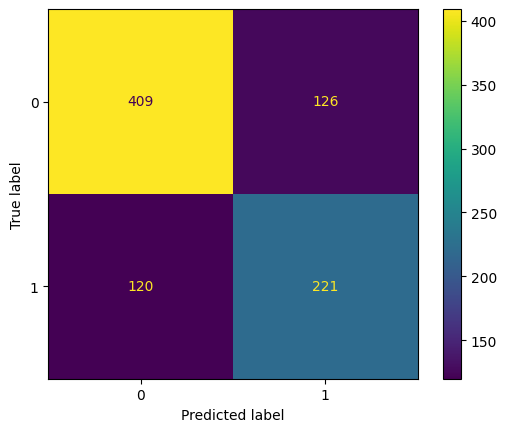

In [63]:
### TO BE COMPLETED ###

kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto', init='k-means++')
kmeans = kmeans.fit(X)

y_pred_kmeans_famd = kmeans.labels_

kmeans_accuracy_famd = np.sum(y_pred_kmeans_famd==y)/y.shape[0]
print("Percentage of points correctly classified: {:.3f}%".format(100*kmeans_accuracy_famd))

ConfusionMatrixDisplay(confusion_matrix(y, y_pred_kmeans_famd)).plot()
plt.show()

In [ ]:
# %load solutions/pred/kmeans_famd.py

#### SVM Model on FAMD Components

- We will run [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for different values of the regularization parameter `C`, and different value of the kernel coefficient `gamma`

- We will use [RandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) to slelect the optimal `C` and `Gamma` hyperparameters.

- For more accurate results, you should use [Gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) instead, but at the cost of computational time.

In [64]:
from sklearn.model_selection import train_test_split

##### <span style="color:purple">**Todo:** Divide the dataset into test and train sets.</span>

- Create test and training matrices containing projections into the FAMD space.
- Create test and training vectors with related 'survived' labels.
- Keep only those dimensions that carry sufficient inertia.
- Refer to the `train_test_split` function of `scikit-learn`

**Note**: When we want to train a (supervised) model, we _always_ need to make such a cut to avoid over-fitting.

In [65]:
### TO BE COMPLETED ###
train, test = train_test_split(titanic_famd, test_size=0.2)

X_train = train[np.arange(5)].to_numpy()
y_train = train['survived'].to_numpy()

X_test = test[np.arange(5)].to_numpy()
y_test = test['survived'].to_numpy()

display(train)

#1ere colonne : on a les anciens index des individus

component,survived,0,1,2,3,4,5,6,7,8
693,0,-0.638105,0.850864,-0.132932,-0.643978,-1.226228,-0.186426,-1.928007,0.215154,-0.357421
565,1,-1.558948,0.025336,3.419860,3.601213,0.572395,0.611147,0.795321,-0.065432,0.016819
801,0,-1.928514,-0.575548,-0.067195,-0.831401,-0.597935,-0.446375,0.052066,0.068372,0.171658
19,1,0.574393,-0.609430,1.657114,0.365196,1.716146,-3.025943,0.579851,-0.254647,0.189917
856,1,2.883514,-0.699456,-0.391906,1.396095,-2.020829,0.178629,-0.086772,-1.165598,-0.294390
...,...,...,...,...,...,...,...,...,...,...
367,0,-1.973373,-0.220838,0.012428,-0.934298,-0.537688,-0.528565,0.264173,0.612533,-0.353724
712,0,-1.257342,-1.149001,-2.694291,0.385448,1.332731,0.921508,-0.114864,-0.630313,0.799554
378,1,2.832554,-0.328188,-0.309287,1.289302,-1.956647,0.090468,0.133202,-0.604989,-0.849167
607,0,-0.557875,0.590699,-0.182824,-0.579233,-1.283665,-0.100935,-2.059564,-0.078225,0.085455


In [ ]:
# %load solutions/pred/train_test_famd.py

##### Random search for best C and Gamma

In [68]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

In [69]:
svm = SVC(random_state=42, probability=True);

distributions = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 1)}
clf = RandomizedSearchCV(svm,
    param_distributions = distributions,
    n_iter = 20, n_jobs = 4, cv = 3,
    random_state = 0,
    scoring = 'roc_auc')

search = clf.fit(X_train, y_train)
print('Optimized Hyperparameters: %s' % search.best_params_)

Optimized Hyperparameters: {'C': 2.2021839744032574, 'gamma': 0.932619845547938}


##### SVM with optimized C and Gamma

In [70]:
from sklearn import metrics

Accuracy of SVM: 78.409%


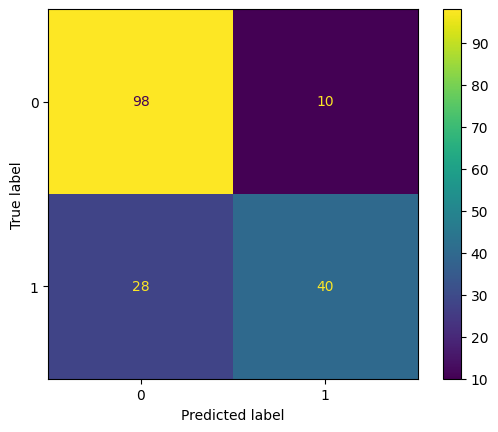

In [71]:
svm = SVC(random_state = 42,
          probability = True,
          kernel = 'rbf',
          gamma =search.best_params_['gamma'],
          C= search.best_params_['C'])

svm.fit(X_train, y_train)

y_pred_svm_famd = svm.predict(X_test)
svm_accuracy_famd = metrics.accuracy_score(y_test, y_pred_svm_famd)
print("Accuracy of SVM: {:.3f}%".format(100*svm_accuracy_famd))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svm_famd)).plot()
plt.show()

#### Logistic Regression on FAMD Components

We can do exactly the same with logistic regression

In [72]:
from sklearn.linear_model import LogisticRegression

In [73]:
logistic = LogisticRegression(random_state=0, solver='saga',
                              tol=1e-2, max_iter=200)

distributions = {"C": stats.uniform(0, 4),
                 "penalty": ['l2', 'l1']}
clf = RandomizedSearchCV(logistic,
    param_distributions = distributions,
    n_iter = 20, n_jobs = 4, cv = 3,
    random_state = 0,
    scoring = 'roc_auc')

search = clf.fit(X_train, y_train)
print('Optimized Hyperparameters: %s' % search.best_params_)

Optimized Hyperparameters: {'C': 0.34851719880616283, 'penalty': 'l1'}


Accuracy of Logistic Regression: 75.568%


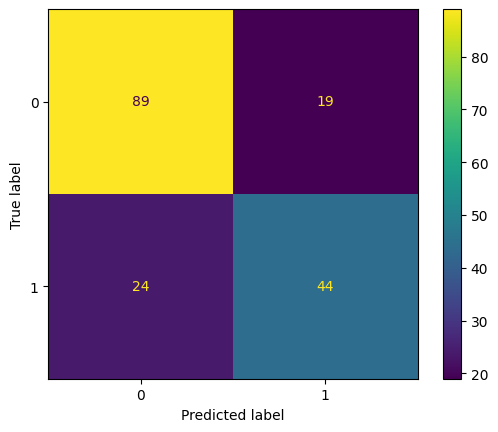

In [75]:
logistic = LogisticRegression(random_state=0,
                              solver='saga', tol=1e-2, max_iter=200,
                              C= search.best_params_['C'],
                              penalty =search.best_params_['penalty'])

logistic.fit(X_train, y_train)

y_pred_logistic_famd = logistic.predict(X_test)
logistic_accuracy_famd = metrics.accuracy_score(y_test, y_pred_logistic_famd)
print("Accuracy of Logistic Regression: {:.3f}%".format(100*logistic_accuracy_famd))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_logistic_famd)).plot()
plt.show()

### MCA for quantitative variables

We saw in the course that we could process both quantitative and qualitative variables at the same time by thresholding the quantitative variables and then applying an MCA to all the variables (which are then all qualitative).

##### <span style="color:purple">**Todo:** Threshold quantitative variables.</span>

1. Threshold quantitative variables
2. View the breakdown of classes created in this way

In [76]:
### TO BE COMPLETED ###

titanic_thresh = titanic_clip.copy()

titanic_thresh['age'] = pd.qcut(titanic_thresh['age'], 4, duplicates='drop')
titanic_thresh['fare'] = pd.cut(titanic_thresh['fare'], [0,8,15,30,100,200,600])

# titanic_mca['age'] = pd.qcut(titanic_mca['age'], 6, duplicates='drop')
# titanic_mca['fare'] = pd.cut(titanic_mca['fare'], [0,8,15,30,60,100,200,600]) #, duplicates='drop'

titanic_thresh = titanic_thresh.astype('category')

In [ ]:
# %load solutions/pred/titanic_thresh.py

[]

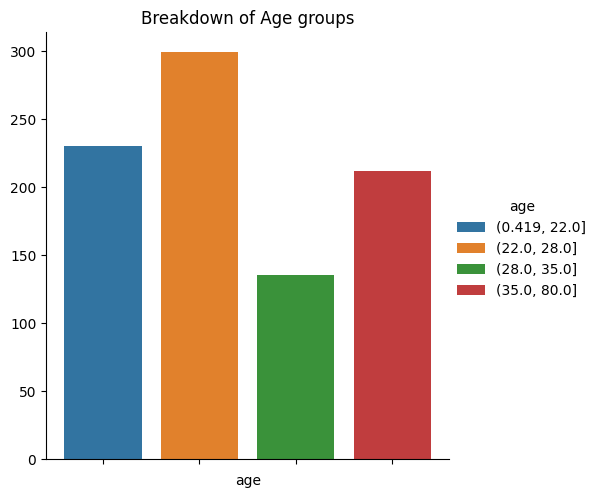

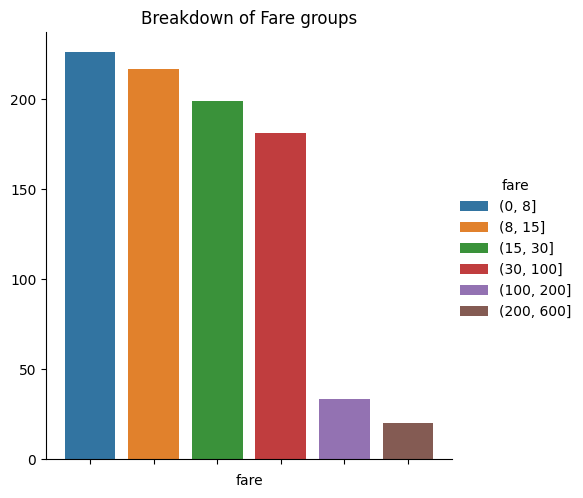

In [77]:
### TO BE COMPLETED ###

p = sns.catplot(data=titanic_thresh, x='age', kind='count', hue='age')
p.set_xticklabels([])
plt.title('Breakdown of Age groups')
plt.ylabel('')
plt.plot()

p = sns.catplot(data=titanic_thresh, x='fare', kind='count', hue='fare')
p.set_xticklabels([])
plt.title('Breakdown of Fare groups')
plt.ylabel('')
plt.plot()

In [ ]:
# %load solutions/pred/breakdown.py

##### <span style="color:purple">**Todo:** Carry out the MCA of the variables thus truncated.</span>

What is inertia like?

In [78]:
### TO BE COMPLETED ###

mca = prince.MCA(
    n_components=15,
    n_iter=20,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(titanic_thresh)

display(mca.eigenvalues_summary)
mca.scree_plot()

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.394,15.77%,15.77%
1,0.305,12.20%,27.98%
2,0.270,10.79%,38.76%
3,0.209,8.37%,47.13%
4,0.180,7.18%,54.31%
5,0.169,6.78%,61.09%
6,0.160,6.39%,67.48%
7,0.157,6.30%,73.78%
8,0.146,5.83%,79.61%


alt.Chart(...)

In [ ]:
# %load solutions/pred/mca.py

##### <span style="color:purple">**Todo:** Observe the distribution of points in MCA space.</span>

One may use a previously coded function.

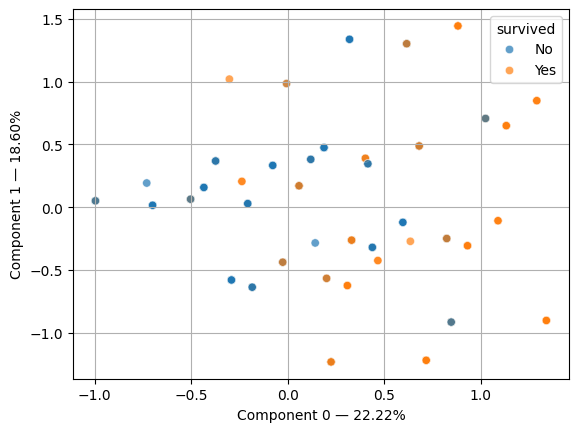

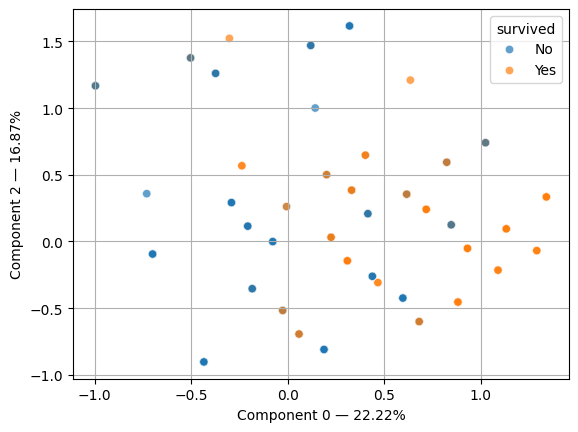

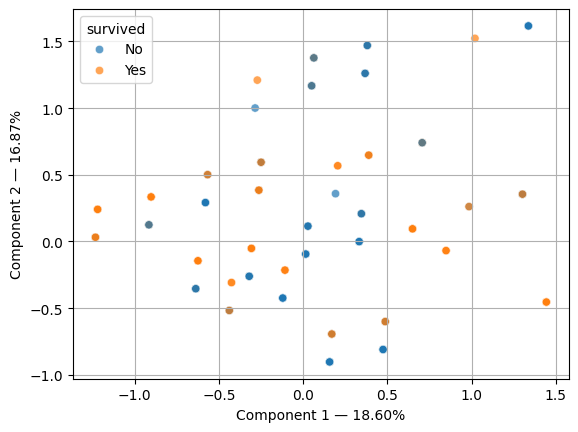

In [79]:
plot_mca(0, 1, data=titanic_thresh)
plot_mca(0, 2, data=titanic_thresh)
plot_mca(1, 2, data=titanic_thresh)

In [ ]:
# %load solutions/pred/plot_mca.py

We are now going to repeat the previous study, but on the MCA space.

In [ ]:
titanic_mca = mca.transform(titanic_thresh)
titanic_mca.reset_index(inplace=True)
titanic_mca['survived'] = titanic_mca['survived'].astype('category').cat.rename_categories({'No': 0, 'Yes':1})

X = titanic_mca.drop('survived', axis=1).to_numpy()
y = titanic_famd['survived'].to_numpy()

#### k-means on MCA Components

##### <span style="color:purple">**Todo:** Classification using the k-means algorithm (or another!)</span>

- How many classes to impose?
- What is the proportion of well-classified points?
- Display the confusion matrix

In [ ]:
### TO BE COMPLETED ###

[...]

In [ ]:
# %load solutions/pred/kmeans_mca.py

#### SVM Model on MCA Components

##### <span style="color:purple">**Todo:** Divide the dataset into test and train sets.</span>

- Create test and training matrices containing projections into the MCA space.
- Create test and training vectors with related 'survived' labels.

In [ ]:
### TO BE COMPLETED ###

[...]

X_train = ...
y_train = ...

X_test = ...
y_test = ...

In [ ]:
# %load solutions/pred/train_test_mca.py

##### SVM with optimized C and Gamma

In [ ]:
svm = SVC(random_state=42, probability=True);

distributions = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 1)}
clf = RandomizedSearchCV(svm,
    param_distributions = distributions,
    n_iter = 20, n_jobs = 4, cv = 3,
    random_state = 0,
    scoring = 'roc_auc')

search = clf.fit(X_train, y_train)
print('Optimized Hyperparameters: %s' % search.best_params_)

In [ ]:
svm = SVC(random_state = 42,
          probability = True,
          kernel = 'rbf',
          gamma =search.best_params_['gamma'],
          C= search.best_params_['C'])

svm.fit(X_train, y_train)

y_pred_svm_mca = svm.predict(X_test)
svm_accuracy_mca = metrics.accuracy_score(y_test, y_pred_svm_mca)
print("Accuracy of SVM: {:.3f}%".format(100*svm_accuracy_mca))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svm_mca)).plot()
plt.show()

#### Logistic Regression on MCA Components

In [ ]:
logistic = LogisticRegression(random_state=0, solver='saga',
                              tol=1e-2, max_iter=200)

distributions = {"C": stats.uniform(0, 4),
                 "penalty": ['l2', 'l1']}
clf = RandomizedSearchCV(logistic,
    param_distributions = distributions,
    n_iter = 20, n_jobs = 4, cv = 3,
    random_state = 0,
    scoring = 'roc_auc')

search = clf.fit(X_train, y_train)
print('Optimized Hyperparameters: %s' % search.best_params_)

In [ ]:
logistic = LogisticRegression(random_state=0,
                              solver='saga', tol=1e-2, max_iter=200,
                              C= search.best_params_['C'],
                              penalty =search.best_params_['penalty'])

logistic.fit(X_train, y_train)

y_pred_logistic_mca = logistic.predict(X_test)
logistic_accuracy_mca = metrics.accuracy_score(y_test, y_pred_logistic_mca)
print("Accuracy of Logistic Regression: {:.3f}%".format(100*logistic_accuracy_mca))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_logistic_mca)).plot()
plt.show()

##### <span style="color:purple">**Todo:** Compare the different accuracies obtained previously.</span>


In [ ]:
### TO BE COMPLETED ###

[...]

In [ ]:
# %load solutions/pred/compare.py